## MonReader Project

### Background:
An AI and computer vision company aims to build a new mobile document digitization experience for the blind. They want to develop a fully automatic and fast app that perfroms high quality document scanning in bulk. To that end, the company wants to develop a solution to identify if book images contain flipped pages or not. The goal is to build a machine learning model that can label images as 'flip' and 'notflip'.

### Data Description:
The data belongs to an organization that develops AI and computer vision solutions. The organization has collected page flipping videos from smartphones and the extracted frames are saved sequentially and labelled 'flip' and 'not flip'.

### Goals:
* Predict if the page is being flipped using a single image.
* Evaluate model performance based on F1 score.
* Predict if a given sequence of images contains an action of flipping.

### Initial Setup
* Import all libraries

In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

* Initialize image folder path and other parameters

In [46]:
tf.debugging.set_log_device_placement(True)

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "images/training"
TEST_DATA_DIR = "images/testing"
EVAL_DIR = "final_evaluation"
BATCH_SIZE=32
EPOCHS=10

* The dataset is labelled 'flip' and 'notflip'

In [47]:
classes = [item for item in os.listdir(TRAINING_DATA_DIR)]
print(classes)

['flip', 'notflip']


* Define helper functions

In [56]:
def visualize_images(path):
    figure = plt.figure(figsize=(5, 5))
    subplot = 1
    data_distribution = []
    
    for folder, subs, files in os.walk(path):
        if not subs:
            data_distribution.append(len(files))
            sampled_image = random.sample(os.listdir(folder), 1)
            figure.add_subplot(1, 2, subplot)
            
            img = tf.io.read_file(os.path.join(folder, sampled_image[0]))
            img = tf.image.decode_image(img)
            plt.imshow(img)
            plt.axis('off')
            plt.title(classes[subplot - 1])
            subplot = subplot + 1            
    plt.show()
    print("Image Size: ", img.shape)
    return data_distribution


def visualize_predictions(directory, model):
    figure = plt.figure(figsize=(10,6))
    subplot = 1
    for i in os.listdir(directory):
        if i.startswith('f'):
            actual = classes[0]
        elif i.startswith('n'):
            actual = classes[1]

        orig_img = tf.io.read_file(os.path.join(directory, i))
        orig_img = tf.image.decode_image(orig_img)
        img = tf.image.resize(orig_img, size=[224, 224])
        img = img/255.

        prediction = model.predict(tf.expand_dims(img, axis=0), verbose=0)
        prediction_class = classes[int(tf.round(prediction))]
        figure.add_subplot(2, 4, subplot)
        plt.imshow(orig_img)
        color = 'green' if actual == prediction_class else 'red'
        plt.title("Prediction: {fpred}".format(fpred=prediction_class), color=color)
        plt.axis(False)
        subplot = subplot + 1
    plt.show()
    

def plot_curves(model):    
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
    ax[0].plot(range(EPOCHS), model.history['accuracy'], label="Training Accuracy")
    ax[0].plot(range(EPOCHS), model.history['val_accuracy'], label="Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    ax[1].plot(range(EPOCHS), model.history['loss'], label="Training Loss")
    ax[1].plot(range(EPOCHS), model.history['val_loss'], label="Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.show()
    
    
def eval_results(actual, predictions):
    # Accuracy
    print("Accuracy of the model on test data : ", accuracy_score(actual, predictions))
    print("#"*100)
    print(classification_report(actual, predictions))
    cm = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print("Total images predicted as class 'flip'", np.bincount(predictions.astype(int))[0])
    print("Total images predicted as class 'notflip'", np.bincount(predictions.astype(int))[1])

#### Visualize images in the dataset

* The following figures show images in the training dataset. Training data contains 2392 images belonging to both the classes

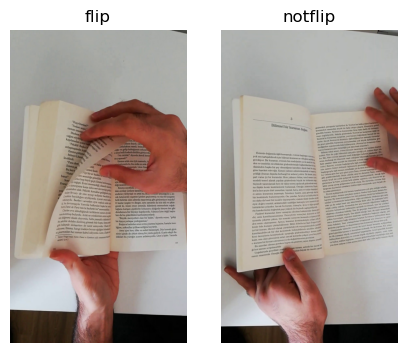

Image Size:  (1920, 1080, 3)


In [49]:
training_data_distribution = visualize_images(TRAINING_DATA_DIR)

* Visualize label distribution in the training dataset

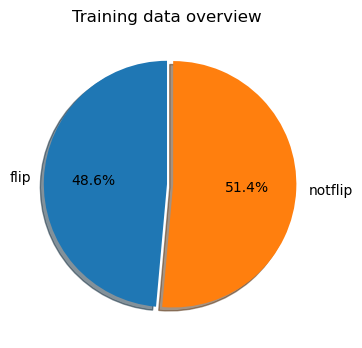

Total number of training images for class flip: 1162
Total number of training images for class notflip: 1230


In [9]:
figure = plt.figure(figsize=(4, 4))
plt.pie(training_data_distribution, 
        labels = classes, 
        explode = (0, 0.05), 
        shadow = True, 
        startangle = 90, 
        autopct='%1.1f%%')
plt.title("Training data overview")
plt.show()
print("Total number of training images for class flip:", training_data_distribution[0])
print("Total number of training images for class notflip:", training_data_distribution[1])

* The following figures show images in the test dataset. test data contains 597 images belonging to both the classes

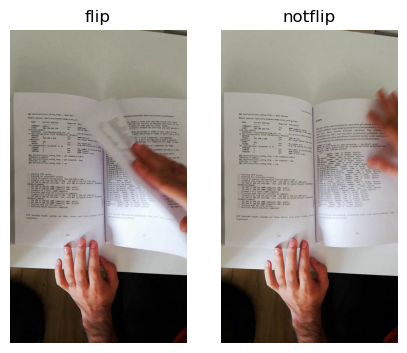

Image Size:  (1920, 1080, 3)


In [50]:
test_data_distribution = visualize_images(TEST_DATA_DIR)

* Visualize label distribution in the test dataset

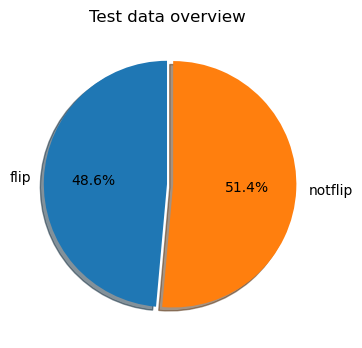

Total number of testing images for class flip: 290
Total number of testing images for class notflip: 307


In [8]:
figure = plt.figure(figsize=(4, 4))
plt.pie(training_data_distribution, 
        labels = classes, 
        explode = (0, 0.05), 
        shadow = True, 
        startangle = 90, 
        autopct='%1.1f%%')
plt.title("Test data overview")
plt.show()
print("Total number of testing images for class flip:", test_data_distribution[0])
print("Total number of testing images for class notflip:", test_data_distribution[1])

From looking at the overview of the label distributions in the dataset, we can see that the labels are uniformly distributed in both training and test datasets.

### Create a custom CNN classifier

We will build a customer CNN to classify images as 'flip' and 'notflip'.

Step 1: Load the images and prepare the training and testing dataset to build a classifier. We have separated the images based on their labels and placed them in different folders.

In [10]:
# Set random Seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(TRAINING_DATA_DIR, 
                                                 batch_size=32, 
                                                 target_size=IMAGE_SHAPE, 
                                                 class_mode="binary",
                                                 shuffle=True,)

test_set = test_datagen.flow_from_directory(TEST_DATA_DIR, 
                                            batch_size=32, 
                                            target_size=IMAGE_SHAPE, 
                                            class_mode="binary",
                                            shuffle=False,)


Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Step 2: Train the neural network with the training dataset and validate it using test dataset.

In [10]:
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])


classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                         loss = 'binary_crossentropy',
                         metrics=["accuracy"])


classifier_model_history = classifier_model.fit(training_set,
                                                steps_per_epoch=training_set.samples//BATCH_SIZE,
                                                epochs=EPOCHS,
                                                validation_data=test_set,
                                                validation_steps=test_set.samples//BATCH_SIZE,)

Epoch 1/10
74/74 [==============================] - 123s 2s/step - loss: 0.6395 - accuracy: 0.6347 - val_loss: 0.4465 - val_accuracy: 0.8351
Epoch 2/10
74/74 [==============================] - 90s 1s/step - loss: 0.2848 - accuracy: 0.8814 - val_loss: 0.2660 - val_accuracy: 0.8819
Epoch 3/10
74/74 [==============================] - 81s 1s/step - loss: 0.1564 - accuracy: 0.9415 - val_loss: 0.2955 - val_accuracy: 0.8889
Epoch 4/10
74/74 [==============================] - 79s 1s/step - loss: 0.1075 - accuracy: 0.9631 - val_loss: 0.1383 - val_accuracy: 0.9497
Epoch 5/10
74/74 [==============================] - 77s 1s/step - loss: 0.0490 - accuracy: 0.9869 - val_loss: 0.0850 - val_accuracy: 0.9809
Epoch 6/10
74/74 [==============================] - 79s 1s/step - loss: 0.0483 - accuracy: 0.9826 - val_loss: 0.0787 - val_accuracy: 0.9705
Epoch 7/10
74/74 [==============================] - 121s 2s/step - loss: 0.0203 - accuracy: 0.9962 - val_loss: 0.0622 - val_accuracy: 0.9740
Epoch 8/10
74/74 [

* Summary of the CNN classifier

In [11]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

Step 3: Visualize the training process.
    
Once the training is complete, accuracy and loss is computed for both training and validation datasets to understand the training process.

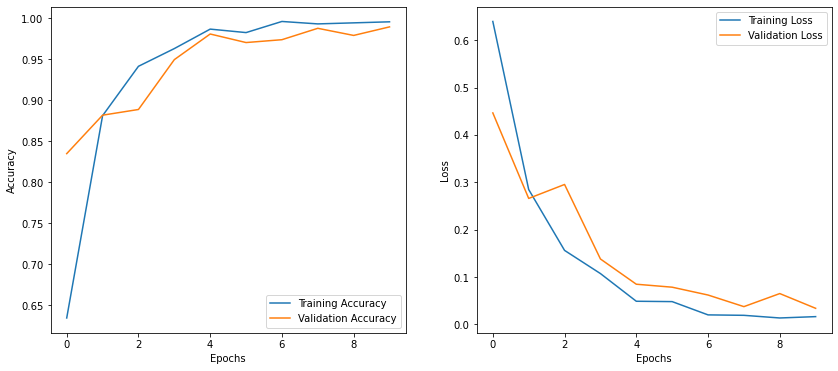

In [12]:
plot_curves(classifier_model_history)

Step 4: Evaluate the model on test data

19/19 [==============================] - 8s 360ms/step
Accuracy of the model on test data :  0.9899497487437185
####################################################################################################
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       290
           1       0.99      0.99      0.99       307

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



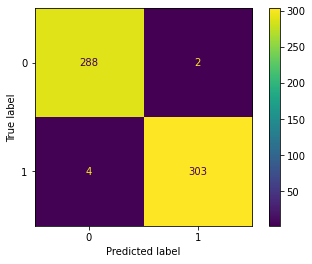

Total images predicted as class 'flip' 292
Total images predicted as class 'notflip' 305


In [13]:
y_test =  test_set.classes

y_pred = classifier_model.predict(test_set)
y_pred = np.rint(y_pred)
y_pred = y_pred.flatten()

eval_results(y_test, y_pred)

We are able to predict the labels of with an accuracy of 98% on the test dataset. The model allows for less than 10 misclassifications and perfroms well on both labels. The model perfroms well on the dataset we have, the model has to be tested on images that do not belong to this distrbution of images to eveluate the generalization power of the developed model. The dataset can be appended by various data augmentation techniques in addition to collecting more images from different distribution.

* Visualize predictions

Correctly labelled images


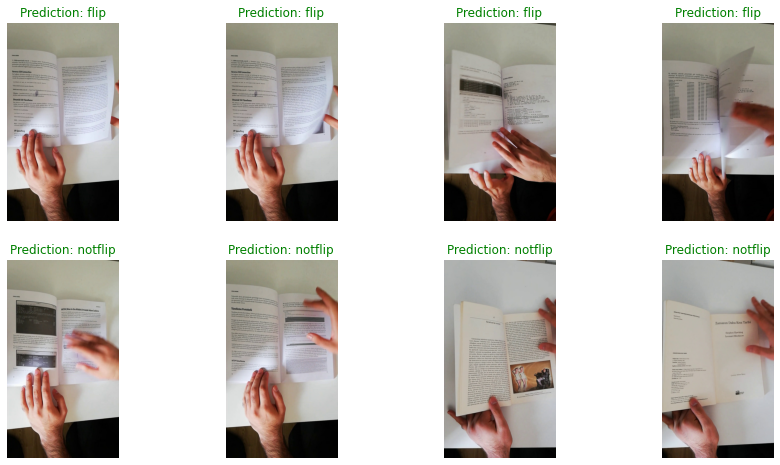

In [14]:
print("Correctly labelled images")
visualize_predictions(EVAL_DIR, classifier_model)

In [ ]:
# Save the model and use it for predictions on the test dataset

classifier_model.save_weights('models/cnn_classifier/checkpoint')

load_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

load_model.load_weights('models/cnn_classifier/checkpoint')

y_test1 =  test_set.classes

y_pred1 = load_model.predict(test_set)
y_pred1 = np.rint(y_pred1)
y_pred1 = y_pred1.flatten()

eval_results(y_test1, y_pred1)

### Transfer Learning

We will use pre-trained efficientnet for the image classification task. EfficientNet is a state of the art image classification neural network.

Step 1: Create a base model from InceptionV3

In this step, we will freeze the convolutional base and use it as a feature extractor.

In [23]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
                                                                      include_top=False,
                                                                      weights="imagenet",)

# Freeze the convolutional base
pre_trained_model.trainable = False

87910968/87910968 [==============================] - 7s 0us/step


In [24]:
base_model = tf.keras.layers.Flatten()(pre_trained_model.output)
#base_model = tf.keras.layers.GlobalAveragePooling2D(name='pooling_layer')(pre_trained_model.output)
base_model = tf.keras.layers.Dense(64, activation='relu')(base_model)
base_model = tf.keras.layers.Dense(1, activation='sigmoid')(base_model)

base_model = tf.keras.Model(pre_trained_model.input, base_model, name='Pre_trained_model')

base_model.summary()

Model: "Pre_trained_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                 

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

Step 2: Compile the model and train it using the training dataset

In [26]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                   loss = 'binary_crossentropy',
                   metrics=["accuracy"])


base_model_history = base_model.fit(training_set,
                                    steps_per_epoch=training_set.samples//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    validation_data=test_set,
                                    validation_steps=test_set.samples//BATCH_SIZE,)

Epoch 1/10
74/74 [==============================] - 111s 1s/step - loss: 1.2347 - accuracy: 0.6403 - val_loss: 0.5295 - val_accuracy: 0.7517
Epoch 2/10
74/74 [==============================] - 101s 1s/step - loss: 0.2958 - accuracy: 0.8831 - val_loss: 0.2006 - val_accuracy: 0.9149
Epoch 3/10
74/74 [==============================] - 90s 1s/step - loss: 0.0793 - accuracy: 0.9640 - val_loss: 0.1089 - val_accuracy: 0.9583
Epoch 4/10
74/74 [==============================] - 99s 1s/step - loss: 0.0359 - accuracy: 0.9831 - val_loss: 0.1240 - val_accuracy: 0.9444
Epoch 5/10
74/74 [==============================] - 90s 1s/step - loss: 0.0181 - accuracy: 0.9953 - val_loss: 0.0512 - val_accuracy: 0.9826
Epoch 6/10
74/74 [==============================] - 110s 1s/step - loss: 0.0100 - accuracy: 0.9983 - val_loss: 0.0699 - val_accuracy: 0.9861
Epoch 7/10
74/74 [==============================] - 118s 2s/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 0.0375 - val_accuracy: 0.9878
Epoch 8/10
74/74

Step 3: Visualize the training process.
    
Once the training is complete, accuracy and loss is computed for both training and validation datasets to understand the training process.

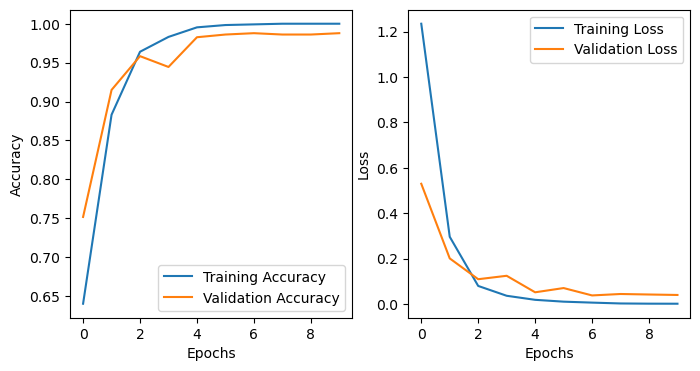

In [53]:
plot_curves(base_model_history)

Step 4: Evaluate the model on test data

19/19 [==============================] - 28s 948ms/step
Accuracy of the model on test data :  0.9882747068676717
####################################################################################################
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       290
           1       0.98      0.99      0.99       307

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



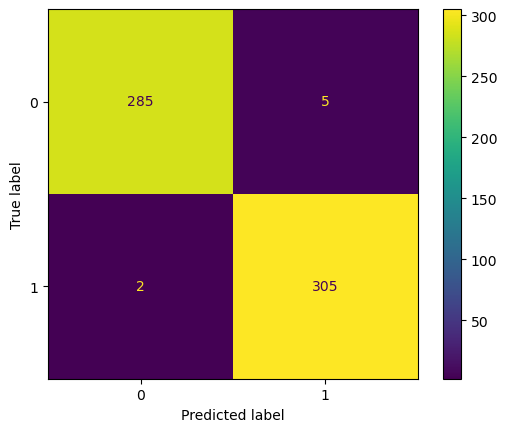

Total images predicted as class 'flip' 287
Total images predicted as class 'notflip' 310


In [54]:
y_test =  test_set.classes

y_pred = base_model.predict(test_set)
y_pred = np.rint(y_pred)
y_pred = y_pred.flatten()

eval_results(y_test, y_pred)

Correctly labelled images


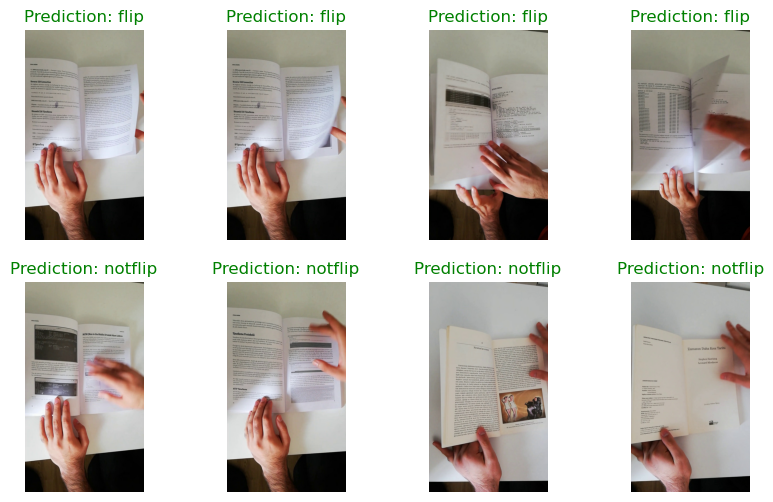

In [57]:
print("Correctly labelled images")
visualize_predictions(EVAL_DIR, base_model)

In [34]:
base_model.save_weights('models/inception_classifier/checkpoint')